<a href="https://colab.research.google.com/github/Tiabet/DACON-code/blob/master/%EB%8C%80%EC%B6%9C%EB%93%B1%EA%B8%89%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
# 데이터 불러오기 및 전처리
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
train_df

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,TRAIN_96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,TRAIN_96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,TRAIN_96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,TRAIN_96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [4]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

train_df = train_df.drop(['ID'],axis=1)
X = train_df.drop(['대출등급'], axis=1)
y = train_df['대출등급']

In [5]:
X = pd.get_dummies(X)

In [8]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_classifier.fit(X, y)

feature_importances = rf_classifier.feature_importances_


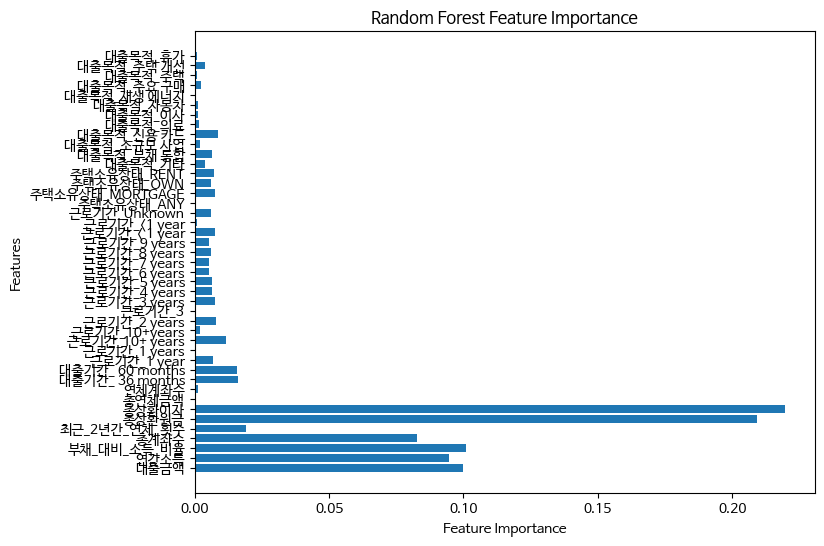

In [9]:
plt.figure(figsize=(8, 6))

plt.rc('font', family='NanumBarunGothic')

plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

1. 대출 목적 비슷한 것들은 묶기
2. 근로기간 언노운 처리하고 1이하랑 1 묶기
3. 주택소유상태 ANY 처리
4. 연체계좌수, 총연체금액 드랍